# Transfer Learning com TensorFlow

In [23]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
import requests
import shutil
from PIL import Image

In [24]:
url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
file_name = 'cats-and-dogs.zip'
os.makedirs('tmp', exist_ok=True)
path_to_zip = os.path.join('tmp', file_name)

if not os.path.exists(path_to_zip):
    print('Downloading...')
    r = requests.get(url)
    if r.status_code == 200:
        with open(path_to_zip, 'wb') as f:
            f.write(r.content)
        print('Download complete')
    else:
        print(f'Download failed with status code {r.status_code}')
else:
    print('File already exists')

Downloading...
Download complete


In [25]:
# Extraindo o arquivo
if not os.path.exists('tmp/PetImages'):
    print('Extracting...')
    with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
        zip_ref.extractall('tmp')

    print('Extraction complete')
else:
    print('Nothing to extract')

Extracting...
Extraction complete


In [26]:
# removento o arquivo zip se ele existir
if os.path.exists(path_to_zip):
    os.remove(path_to_zip)
    print('Removed zip file')

Removed zip file


In [27]:
# Definindo os diretórios
base_dir = 'tmp/PetImages'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

In [28]:
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verifica se a imagem está corrompida
        return True
    except (IOError, SyntaxError) as e:
        print(f'Imagem corrompida: {file_path}')
        return False

In [29]:
# split dados em treino e validação
for animal in ['Cat', 'Dog']:
    os.makedirs(os.path.join(train_dir, animal), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, animal), exist_ok=True)

    animal_dir = os.path.join(base_dir, animal)
    all_images = os.listdir(animal_dir)
    n = len(all_images)
    n_train = int(n * 0.8)
    train_images = all_images[:n_train]
    validation_images = all_images[n_train:]

    for image in train_images:
        src = os.path.join(animal_dir, image)
        dst = os.path.join(train_dir, animal, image)
        if is_valid_image(src):
            shutil.copy2(src, dst)

    for image in validation_images:
        src = os.path.join(animal_dir, image)
        dst = os.path.join(validation_dir, animal, image)
        if is_valid_image(src):
            shutil.copy2(src, dst)

Imagem corrompida: tmp/PetImages/Cat/666.jpg
Imagem corrompida: tmp/PetImages/Cat/Thumbs.db


/usr/local/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Imagem corrompida: tmp/PetImages/Dog/11702.jpg
Imagem corrompida: tmp/PetImages/Dog/Thumbs.db


In [30]:
model = tf.keras.models.Sequential([
    Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [31]:
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

In [32]:
train_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_datagen = ImageDataGenerator(rescale=1.0/255.)

In [33]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=250, class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=250, class_mode='binary')

Found 19998 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [34]:
history = model.fit(
    train_generator,
    epochs=15,
    steps_per_epoch=80,  
    validation_data=validation_generator,
    validation_steps=40,
    verbose=1
)

Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - acc: 0.5348 - loss: 0.7889 - val_acc: 0.6236 - val_loss: 0.6656
Epoch 2/15


/usr/local/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


80/80 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - acc: 0.6337 - loss: 0.6390 - val_acc: 0.6498 - val_loss: 0.6228
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - acc: 0.7007 - loss: 0.5717 - val_acc: 0.6992 - val_loss: 0.5620
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - acc: 0.7266 - loss: 0.5442 - val_acc: 0.7296 - val_loss: 0.5475
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - acc: 0.7317 - loss: 0.5237 - val_acc: 0.7622 - val_loss: 0.5029
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - acc: 0.7755 - loss: 0.4738 - val_acc: 0.7422 - val_loss: 0.5195
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - acc: 0.7907 - loss: 0.4456 - val_acc: 0.7862 - val_loss: 0.4454
Epoch 8/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - acc: 0.7969 - loss: 0.4277 - val_acc: 0.7806 - val_loss: 0.4679
Epoch 9/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - acc: 0.8141 - loss: 0.3993 - val_acc: 0.8034 - val_loss: 0.4165
Epoch 10/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - acc: 0.8197 - loss: 0.3

In [40]:
# Salvando o modelo

model.save('cats_and_dogs.keras')

In [41]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

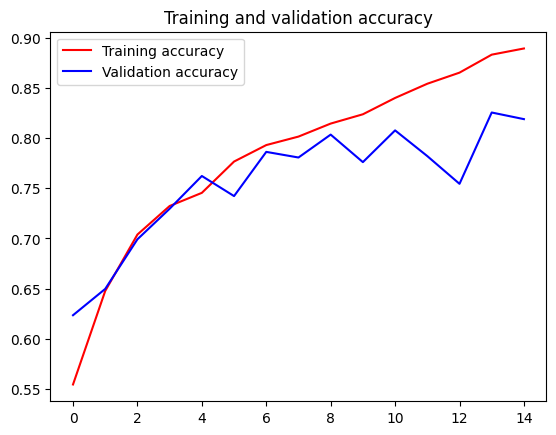

<Figure size 640x480 with 0 Axes>

In [37]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

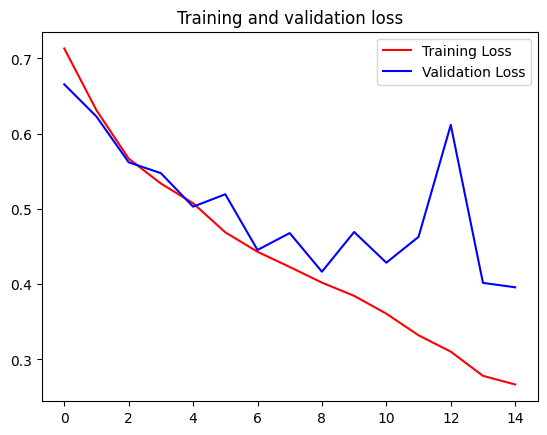

<Figure size 640x480 with 0 Axes>

In [38]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [42]:
gato = Image.open('img/gato.jpg')
cachorro = Image.open('img/cachorro.jpg')

In [43]:
width_gato, height_gato = gato.size
width_cachorro, height_cachorro = cachorro.size

In [44]:
print(f'Gato: {width_gato}x{height_gato}')
print(f'Cachorro: {width_cachorro}x{height_cachorro}')

Gato: 3452x5178
Cachorro: 4710x7064


In [45]:
np_gato = np.array(gato.getdata()).reshape(height_gato, width_gato, 3).astype(np.uint8)

In [46]:
np_cachorro = np.array(cachorro.getdata()).reshape(height_cachorro, width_cachorro, 3).astype(np.uint8)

In [47]:
# Redimensionando as imagens
gato_resized = gato.resize((150, 150))
cachorro_resized = cachorro.resize((150, 150))

In [48]:
np_gato_resized = np.array(gato_resized.getdata()).reshape(150, 150, 3).astype(np.uint8)
np_cachorro_resized = np.array(cachorro_resized.getdata()).reshape(150, 150, 3).astype(np.uint8)

In [49]:
np_gato_resized = np_gato_resized / 255.0
np_cachorro_resized = np_cachorro_resized / 255.0

In [50]:
np_gato_resized.shape, np_cachorro_resized.shape

((150, 150, 3), (150, 150, 3))

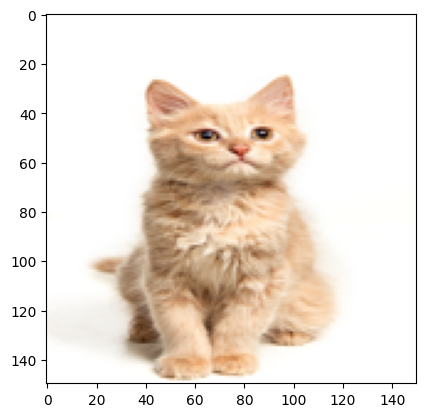

In [51]:
# mostrando as imagens
plt.imshow(np_gato_resized)

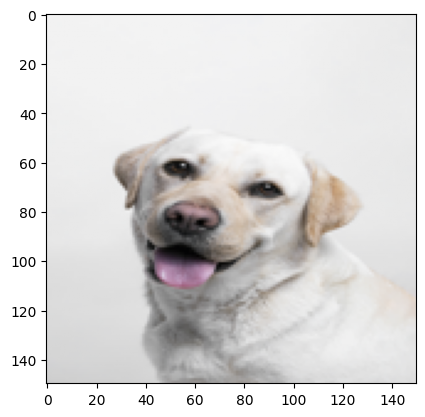

In [52]:
plt.imshow(np_cachorro_resized)

In [53]:
# Resultado da predição
result_gato = model.predict(np_gato_resized.reshape(1, 150, 150, 3))
result_cachorro = model.predict(np_cachorro_resized.reshape(1, 150, 150, 3))

print(f'Gato: {result_gato[0][0]*100:.2f}%')
print(f'Cachorro: {result_cachorro[0][0]*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Gato: 54.04%
Cachorro: 63.48%
